### Keras and Tensorflow Neural Network (NN)

In [38]:
import pandas as pd
from processing_utils import *
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from keras.wrappers.scikit_learn import KerasRegressor
import random

raw_dataset = pd.read_csv('./dataset/data.csv')
dataset = encode_smiles_column_of(
    prune_dataset_lines(
        raw_dataset,
        remove_nan_lines=False,
        remove_nan_cols=True,
        remove_duplicates=True,
        in_favour_of_col='Energy_(kcal/mol)'
    ),
    strategy='count_encoding')

# Tiny Neural Networks with SGD gradient descent

### Cross Validation Score

In [39]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

def cross_validation_of(compiled_neural_network: keras.Model, X: pd.DataFrame, y: pd.DataFrame, epochs=150, batch_size=500, n_splits=5):
    assert y.ndim == 1 or y.shape[1] == 1 
    
    kf = KFold(n_splits=n_splits)
    es = EarlyStopping(monitor='val_loss', patience=20, verbose=0, restore_best_weights=True)
    cross_validation_scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.to_numpy()[train_index], X.to_numpy()[test_index]
        y_train, y_test = y.to_numpy()[train_index].reshape(-1, 1), y.to_numpy()[test_index].reshape(-1, 1)

        features_scaler = StandardScaler()
        target_scaler = StandardScaler()

        compiled_neural_network.fit(
            x=features_scaler.fit_transform(X_train), y=target_scaler.fit_transform(y_train), 
            epochs=epochs, batch_size=batch_size, 
            validation_data=(features_scaler.transform(X_test), target_scaler.transform(y_test)), # the model is not trained on this but tested on it.
            callbacks=[es], verbose=0
        )

        cross_validation_scores.append(
            r2_score(
                compiled_neural_network.predict(features_scaler.transform(X_test)), 
                target_scaler.transform(y_test)
            )
        )
    return cross_validation_scores

### Preparing Cross-Validation Data

In [57]:
seed = random.randint(0, 10000)
random_state = np.random.RandomState(seed)
X_train, y_train, X_test, y_test = get_train_data(
    dataset,
    targets_columns=['Energy_(kcal/mol)', 'Energy DG:kcal/mol)'],
    random_state=random_state,
    as_numpy=False,
    validation=False
)

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

In [41]:
tiny_model_Energy_ = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_dim=36),
    keras.layers.Dense(1)   
])

tiny_model_Energy_.compile(
    loss='mse', 
    optimizer=SGD(learning_rate=1e-3, momentum=0), 
    metrics=['mse', tfa.metrics.r_square.RSquare()]     
)

tiny_model_EnergyDG = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_dim=36),
    keras.layers.Dense(1)   
])

tiny_model_EnergyDG.compile(
    loss='mse', 
    optimizer=SGD(learning_rate=1e-3, momentum=0), 
    metrics=['mse', tfa.metrics.r_square.RSquare()]     
)

cross_validation_score_Energy_ = cross_validation_of(tiny_model_Energy_, X=X, y=y['Energy_(kcal/mol)'])
cross_validation_score_EnergyDG = cross_validation_of(tiny_model_EnergyDG, X=X, y=y['Energy DG:kcal/mol)'])

81/81 [==============================] - 0s 719us/step


In [42]:
print("tiny_model_Energy_ Cross Validation Score =", np.array(cross_validation_score_Energy_).mean())
print("tiny_model_EnergyDG Cross Validation Score =", np.array(cross_validation_score_EnergyDG).mean())

tiny_model_Energy_ Cross Validation Score = 0.9738753230360985
tiny_model_EnergyDG Cross Validation Score = 0.9731510126234368


## Optimization History Visualisation

In [55]:
def compute_optimization_history_of(
    compiled_model, X_train: pd.DataFrame, y_train: pd.DataFrame, 
    X_test: pd.DataFrame, y_test: pd.DataFrame):
    
    es = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)

    features_scaler = StandardScaler()
    target_scaler = StandardScaler()
    
    history = compiled_model.fit(
        features_scaler.fit_transform(X_train), target_scaler.fit_transform(y_train.to_numpy().reshape(-1, 1)), 
        epochs=150, batch_size=500, 
        validation_data=(features_scaler.transform(X_test), target_scaler.transform(y_test.to_numpy().reshape(-1, 1))),
        callbacks=[es], verbose=0)

    return history

In [58]:
import tensorflow_docs as tfdocs
import matplotlib.pyplot as plt
import tensorflow_docs.plots

sgd_histories = {}
sgd_histories['tiny_model_Energy_'] = compute_optimization_history_of(tiny_model_Energy_, X_train, y_train['Energy_(kcal/mol)'], X_test, y_test['Energy_(kcal/mol)'])
sgd_histories['tiny_model_EnergyDG'] = compute_optimization_history_of(tiny_model_EnergyDG, X_train, y_train['Energy DG:kcal/mol)'], X_test, y_test['Energy DG:kcal/mol)'])

(9648, 1)
(3217, 1)
YOYOYO
(9648, 1)
(3217, 1)
YOYOYO


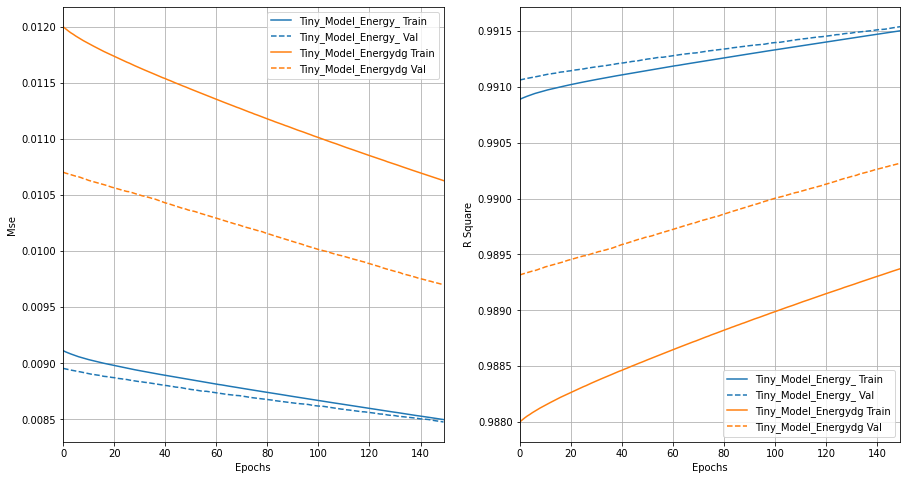

In [61]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.yscale("linear")
plotter = tfdocs.plots.HistoryPlotter(metric='mse')
plotter.plot(sgd_histories)

plt.subplot(1, 2, 2)
plt.yscale("linear")
plotter = tfdocs.plots.HistoryPlotter(metric='r_square')
plotter.plot(sgd_histories)


# Tiny Neural Networks with Adam Optimizer

In [62]:
from keras.optimizers import Adam

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.1, decay_steps=1000, decay_rate=0.96, staircase=False)

tiny_model_Energy_.compile(
    loss='mse', 
    optimizer=Adam(lr_schedule), 
    metrics=['mse', tfa.metrics.r_square.RSquare()]     
)

tiny_model_EnergyDG = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_dim=36),
    keras.layers.Dense(1)   
])

tiny_model_EnergyDG.compile(
    loss='mse', 
    optimizer=Adam(lr_schedule), 
    metrics=['mse', tfa.metrics.r_square.RSquare()]     
)

## Cross Validation Score

In [65]:
cross_validation_score_Energy_ = cross_validation_of(tiny_model_Energy_, X=X, y=y['Energy_(kcal/mol)'])
cross_validation_score_EnergyDG = cross_validation_of(tiny_model_EnergyDG, X=X, y=y['Energy DG:kcal/mol)'])

81/81 [==============================] - 0s 722us/step


In [66]:
print("tiny_model_Energy_ Cross Validation Score with Adam =", np.array(cross_validation_score_Energy_).mean())
print("tiny_model_EnergyDG Cross Validation Score with Adam =", np.array(cross_validation_score_EnergyDG).mean())

tiny_model_Energy_ Cross Validation Score = 0.9993396754559379
tiny_model_EnergyDG Cross Validation Score = 0.9994580694683762


## Optimization History

In [77]:
adam_histories = {}
adam_histories['tiny_model_Energy_'] = compute_optimization_history_of(tiny_model_Energy_, X_train, y_train['Energy_(kcal/mol)'], X_test, y_test['Energy_(kcal/mol)'])
adam_histories['tiny_model_EnergyDG'] = compute_optimization_history_of(tiny_model_EnergyDG, X_train, y_train['Energy DG:kcal/mol)'], X_test, y_test['Energy DG:kcal/mol)'])

(9648, 1)
(3217, 1)
Restoring model weights from the end of the best epoch: 16.
Epoch 36: early stopping
YOYOYO
(9648, 1)
(3217, 1)
Restoring model weights from the end of the best epoch: 1.
Epoch 21: early stopping
YOYOYO


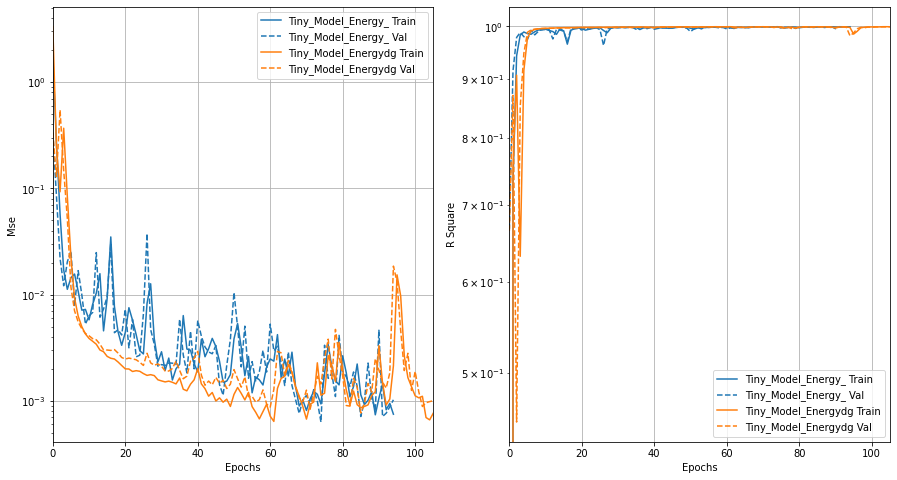

In [64]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.yscale("log")
plotter = tfdocs.plots.HistoryPlotter(metric='mse')
plotter.plot(adam_histories)

plt.subplot(1, 2, 2)
plt.yscale("log")
plotter = tfdocs.plots.HistoryPlotter(metric='r_square')
plotter.plot(adam_histories)

# Fat Neural Network with Adam Optimizer 

In [76]:
fat_model_Energy_ = keras.Sequential([
    keras.layers.Dense(512, activation='relu', input_dim=36),
    keras.layers.Dense(512, activation='relu', input_dim=512),
    keras.layers.Dense(512, activation='relu', input_dim=512),
    keras.layers.Dense(1, activation='linear')
])

fat_model_EnergyDG = keras.Sequential([
    keras.layers.Dense(512, activation='relu', input_dim=36),
    keras.layers.Dense(512, activation='relu', input_dim=512),
    keras.layers.Dense(512, activation='relu', input_dim=512),
    keras.layers.Dense(1, activation='linear')
])


fat_model_Energy_.compile(
    loss='mse', 
    optimizer=Adam(lr_schedule), 
    metrics=['mse', tfa.metrics.r_square.RSquare()]     
) 

fat_model_EnergyDG.compile(
    loss='mse', 
    optimizer=Adam(lr_schedule), 
    metrics=['mse', tfa.metrics.r_square.RSquare()]
) 

## Cross-Validation Score

In [ ]:
cross_validation_score_Energy_ = cross_validation_of(fat_model_Energy_, X=X, y=y['Energy_(kcal/mol)'])
cross_validation_score_EnergyDG = cross_validation_of(fat_model_EnergyDG, X=X, y=y['Energy DG:kcal/mol)'])

In [ ]:
print("tiny_model_Energy_ Cross Validation Score with Adam =", np.array(cross_validation_score_Energy_).mean())
print("tiny_model_EnergyDG Cross Validation Score with Adam =", np.array(cross_validation_score_EnergyDG).mean())

## Optimization History

In [74]:
adam_histories['fat_model_Energy_'] = compute_optimization_history_of(fat_model_Energy_, X_train, y_train['Energy_(kcal/mol)'], X_test, y_test['Energy_(kcal/mol)'])
adam_histories['fat_model_EnergyDG'] = compute_optimization_history_of(fat_model_EnergyDG, X_train, y_train['Energy DG:kcal/mol)'], X_test, y_test['Energy DG:kcal/mol)'])

(9648, 1)
(3217, 1)
Restoring model weights from the end of the best epoch: 31.
Epoch 51: early stopping
YOYOYO
(9648, 1)
(3217, 1)
YOYOYO


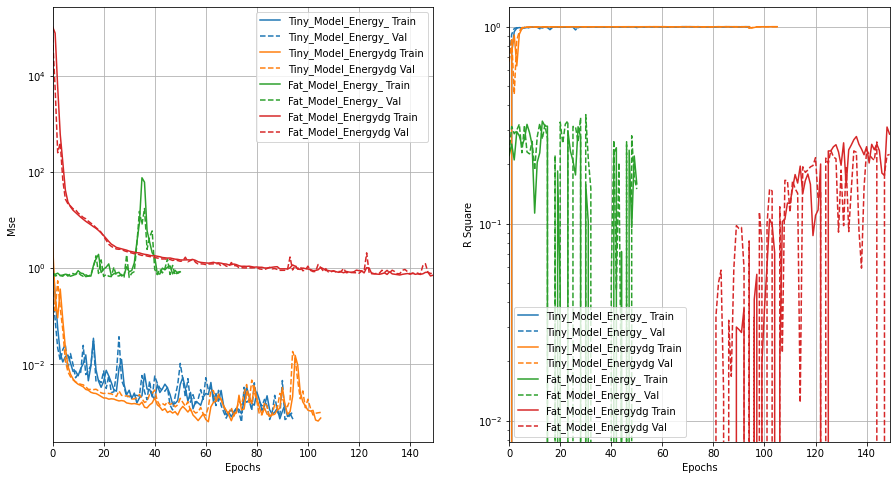

In [75]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.yscale("log")
plotter = tfdocs.plots.HistoryPlotter(metric='mse')
plotter.plot(adam_histories)

plt.subplot(1, 2, 2)
plt.yscale("log")
plotter = tfdocs.plots.HistoryPlotter(metric='r_square')
plotter.plot(adam_histories)

In [61]:
fat_model_Energy_.compile(
    loss='mse', 
    optimizer=Adam(lr_schedule), 
    metrics=['mse', tfa.metrics.r_square.RSquare()]     # HUGO TODO : fine tune gradient hyperparameters via Optuna
)

fat_model_EnergyDG.compile(
    loss='mse', 
    optimizer=Adam(lr_schedule), 
    metrics=['mse', tfa.metrics.r_square.RSquare()]     # HUGO TODO : fine tune gradient hyperparameters via Optuna
)

In [62]:
adam_histories['fat_Energy_'] = fat_model_Energy_.fit(X_train, y_train[:, 0], epochs=150, batch_size=500, validation_data=(X_val, y_val[:, 0]))
adam_histories['fat_EnergyDG'] = fat_model_EnergyDG.fit(X_train, y_train[:, 1], epochs=150, batch_size=500, validation_data=(X_val, y_val[:, 1]))

Epoch 1/150
19/19 [==============================] - 1s 24ms/step - loss: 0.6569 - mse: 0.6569 - r_square: 0.3431 - val_loss: 0.1122 - val_mse: 0.1122 - val_r_square: 0.8878
Epoch 2/150
19/19 [==============================] - 0s 21ms/step - loss: 0.0872 - mse: 0.0872 - r_square: 0.9128 - val_loss: 0.0373 - val_mse: 0.0373 - val_r_square: 0.9627
Epoch 3/150
19/19 [==============================] - 0s 18ms/step - loss: 0.0286 - mse: 0.0286 - r_square: 0.9714 - val_loss: 0.0168 - val_mse: 0.0168 - val_r_square: 0.9832
Epoch 4/150
19/19 [==============================] - 0s 18ms/step - loss: 0.0112 - mse: 0.0112 - r_square: 0.9888 - val_loss: 0.0083 - val_mse: 0.0083 - val_r_square: 0.9917
Epoch 5/150
19/19 [==============================] - 0s 18ms/step - loss: 0.0061 - mse: 0.0061 - r_square: 0.9939 - val_loss: 0.0059 - val_mse: 0.0059 - val_r_square: 0.9941
Epoch 6/150
19/19 [==============================] - 0s 19ms/step - loss: 0.0044 - mse: 0.0044 - r_square: 0.9956 - val_loss: 0.00

NameError: name 'adam_histories' is not defined

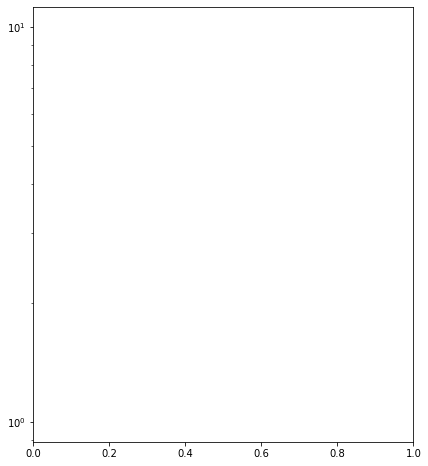

In [16]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.yscale("log")
plotter = tfdocs.plots.HistoryPlotter(metric='mse')
plotter.plot(adam_histories)

plt.subplot(1, 2, 2)
#plt.yscale("log")
plotter = tfdocs.plots.HistoryPlotter(metric='r_square')
plotter.plot(adam_histories)